In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("<style>.container { width: 90% !important; }</style>")

In [2]:
import utils

import sneks
import gym

from tqdm.notebook import trange
import numpy as np
import torch
import torch.nn as nn

utils.info

{'torch_version': '1.3.1', 'torch_device': 'cuda', 'gym_version': '0.17.1'}

In [3]:
utils.use_virtual_display()

':1069'

In [4]:
# env = gym.make('snek-rgb-16-v1')
env = gym.make('CartPole-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

num_actions = env.action_space.n
obs_size = np.prod(env.observation_space.shape)

obs_size, num_actions, env.reward_range, # env.unwrapped.unwrapped.get_action_meanings()

(4, 2, (-inf, inf))

In [5]:
dqn = utils.DQNAgent(obs_size, num_actions)
dqn.make_persisted('./.models/dqn2.pkl')

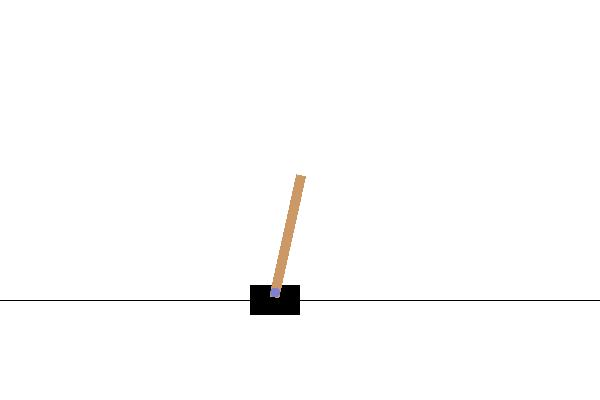

In [6]:
dqn_play_env = utils.play_env(env, dqn, duration=100)
utils.i_python_display_frames(dqn_play_env, fps=60)

In [7]:
generator = utils.ExperienceGenerator()(env, dqn, bs=100)
batch = next(generator)
[t.shape for t in batch]

[(100, 4), (100,), (100,), (100, 4), (100,)]

In [8]:
def train():
    %matplotlib notebook
    its = 10_000

    generator = utils.ExperienceGenerator()
    next_batch = generator(env, dqn, bs=128)
    optimize = dqn.optimizer(next_batch, lr=0.001)
    plotter = utils.Plotter()

    tr = trange(its, bar_format="{bar}{l_bar}{r_bar}")
    for i in tr:
        info = next(optimize)
        plotter.log(**info)
        plotter.log(episode_rewards=generator.episode_rewards[:-1])
        plotter.log(randomness_list=generator.randomness_list)

        tr.set_description(' | '.join([
            'LOSS: %.6f' % info['loss'],
            'EP REWARD: %.2f' % np.mean(generator.episode_rewards[-5:-1]),
        ]))

        if i % 200 == 0: plotter.plot()


if dqn.can_be_preloaded():
    print('Loading pretrained model')
    dqn.load_persisted_if_exists()
else:
    print('No pretrained model found. Training...')
    train()
    dqn.persist()

Loading pretrained model


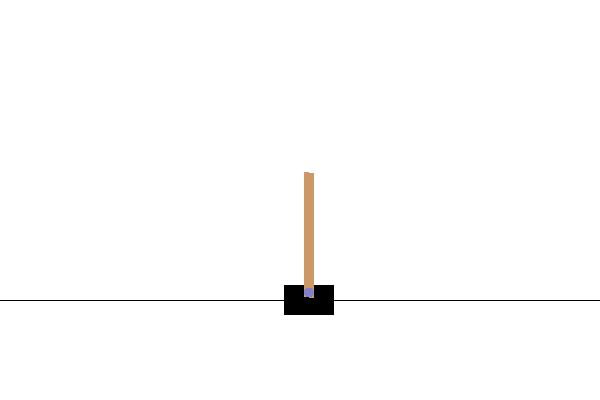

In [9]:
utils.i_python_display_frames(frames_generator=utils.play_env(env, dqn, duration=100), fps=60)

In [10]:
def randomly_good_agent(obs):
    if np.random.uniform() < 0.5:
        return env.action_space.sample()
    else:
        return dqn(obs)

In [11]:
# def render_rollout():
#     gen = utils.rollout_generator(env, agent=randomly_good_agent, bs=16, max_seq_len=20, buffer_size=50, frame_size=(100, 100))
#     i = 100

#     for ep_id, actions, observations, renders_batch in gen:
#         for renders in renders_batch:
#             for r in renders:
#                 i -= 1
#                 if i <= 0: return

#                 yield r
                
# utils.i_python_display_frames(render_rollout(), fps=30)

# g = utils.rollout_generator(env, agent=randomly_good_agent, bs=16, max_seq_len=20, buffer_size=50)
# batch = next(g)
# [b.shape for b in batch]

In [24]:
num_rollouts = 1000
frame_size = (100, 100)
num_actions = env.action_space.n

world_model = utils.RNNWorldRepresentations((*frame_size, 3), num_actions, num_rollouts)
world_model

(100, 100, 3)


RNNWorldRepresentations(
  (precondition): Embedding(1000, 128)
  (action_encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
  )
  (time_transition): GRU(128, 64, num_layers=2, batch_first=True)
  (obs_decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=30000, bias=True)
      (1): Sigmoid()
    )
    (3): Lambda()
  )
)

In [25]:
def next_preprocessed_batch():
    gen = utils.rollout_generator(
        env,
        agent=randomly_good_agent,
        bs=16,
        max_seq_len=20,
        buffer_size=50,
        frame_size=frame_size,
    )
    
    for ep_id, actions, observations, frames in gen:
        frames = frames / 255
        actions = utils.one_hot(actions.astype(np.int32))

        yield (ep_id, actions), frames

<IPython.core.display.Javascript object>


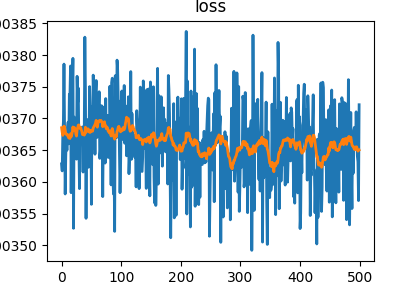

In [ ]:
%matplotlib notebook
its = 10_000

next_batch = next_preprocessed_batch()
optimize = world_model.optimizer(next_batch, lr=0.001)
plotter = utils.Plotter()

tr = trange(its, bar_format="{bar}{l_bar}{r_bar}")
for i in tr:
    info = next(optimize)
    plotter.log(**info)

    tr.set_description(' | '.join([
        'LOSS: %.6f' % info['loss'],
    ]))

    if i % 200 == 0: plotter.plot()